# Reconocimiento de imágenes con YOLO9000
**Universidad de Chile**<br>
**Facultad de Ciencias, Física y Matemáticas**<br>
**Departamento de Ciencias de Computación**<br>
**CC5509 - Reconocimiento de Patrones**<br>
<br>
*Profesores:*<br>
**José M. Saavedra R.**<br>
**Mauricio Cerda Villablanca**<br>
<br>
*Ayudante:*<br>
**Camila Álvarez I.**<br>
<br>
*Alumnos:*<br>
**Cristobal Dotte**<br>
**Gabriel De La Parra**<br>

## Introducción

En este proyecto, se trabajó con [YOLO9000](https://pjreddie.com/darknet/yolo/) para hacer detección y clasificación de objetos en imágenes.

El [paper](https://arxiv.org/abs/1612.08242) fue escrito por Joseph Redmon y Ali Farhadi en Diciembre del 2016, por lo que se puede considerar como un trabajo en el *state-of-the-art*.

YOLO (You Only Look Once) en la versión YOLO9000 propone varias mejoras al sistema YOLO original de los mismos autores. Esta versión lleva el nombre 9000 ya que puede detectar sobre 9000 clases de objetos. Las mejores a esta versión provienen de sugerencias de otros autores y técnicas implementadas por otros sistemas. 

Uno de los aspectos más importantes de YOLO, es que puede correr a 67FPS con un mAP (*Mean Average Precision*) del 76.8 en VOC 2007. Este resultado es mucho mejor que otras técnicas existentes actualmente y a una velocidad mucho mayor. Los detalles sobre la comparación se pueden encontrar en el Paper.

El objetivo de este proyecto será realizar detección sobre carteles de precios en imágenes de frutas y verduras de ferias libres y la vega.

## Procedimiento

Se realizó el siguiente procedimiento para lograr el reconocimiento y clasificación de las imágenes:

1. Construcción del dataset
    1. Obtención de imágenes
    2. Preprocesamiento
    2. Etiquetado
    3. Adaptación de etiquetas
2. Entrenamiento
    1. Descarga YOLO
    2. Compilación
    3. Pruebas
    4. Archivos de configuración
    4. Train y Test Set
    5. Entrenamiento
3. Pruebas
    1. Pruebas
    2. Resultados
4. Conclusiones

## Dataset

En este proyecto, se trabajará con un dataset generado desde cero. El dataset está compuesto por 878 imágenes. Del total, se utilizarán 483 imágenes para entrenar el sistema. Las fotos fueron etiquetadas ocupando la herramienta [LabelImg](https://github.com/tzutalin/labelImg). Dicha herramienta tiene un formato de salida que no es el mismo que requiere YOLO. Fue necesario crear un script para convertir los archivos de salida.

### Obtención de imágenes

Las imágenes fueron tomadas en la vega y en dos ferias libres de Santiago de Chile.

A continuación se presenta un sample de algunas de estas fotos.

In [112]:
from IPython.display import Image, HTML, display
from glob import glob
imagesList=''.join( ["<img style='width: 270px; margin: 2px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
                 for s in sorted(glob('feria labeled/*.jpg')[1:100:10]) ])
display(HTML(imagesList))

## Preprocesamiento

Cada imagen tiene originalmente nombres como: `Foto 03-11-17 14 47 04.jpg` y tiene una resolución de `3264x2448`

### Resize
Si bien la resolución inicial tiene más detalle, no es necesario tanta resolución para entrenar las imagenes, debido a que YOLO hace transformación de las imagenes. Otro problema de trabajar con las imagenes a tan gran resolución, es que copiarlas al servidor ocupa mucho más recursos/tiempo. El set original tiene 2.5gb. El nuevo, 90 mb. 

Como se verá más adelante, se entrenó con la resolución de `418x418`. Se redujo en tamaño al `20%`, que corresponde a `693x490`.

``` bash
$ for a in *.jpg; do convert "$a" -resize 20% resized/"$a"; done
```

![resize](images/resize.png)

### Rename
Los nombres de las imagenes no influyen mucho, sin embargo son maś complicados para seleccionar al momento de usarlos para testear. Por lo mismo, se renombraron las imagenes de forma secuencial. El código que se utilizó es el siguiente.

``` bash
$ ls | cat -n | while read n f; do mv "$f" "$n.jpg"; done
```

![rename](images/rename.png)

## Etiquetado

Se utilizó la herramienta [LabelImg](https://github.com/tzutalin/labelImg) para etiquetar las imagenes. A continuación se presenta una muestra de la interfáz gráfica de la herramienta:

![labelimg](images/labelimg.png)

Uno de los beneficios de utilizar esta herramienta, es que se pueden utilizar distintas clases para las imágenes. Adicionalmente, la herramienta tiene comandos:
- `w`: crear un cuadro
- `a`: imagen anterior
- `d`: imagen siguiente

Por cada imagen, se crea un archivo de formato xml. El archivo tiene el siguiente contenido:

In [27]:
!head -25 1.xml

<annotation>
	<folder>feria</folder>
	<filename>1.jpg</filename>
	<path>/home/clgadel/labeler/feria/1.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>653</width>
		<height>490</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>manzana</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>192</xmin>
			<ymin>285</ymin>
			<xmax>227</xmax>
			<ymax>317</ymax>
		</bndbox>
	</object>


## Adaptación de etiquetas

Para el procesamiento de las etiquetas utilizaremos la librería [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/).

In [28]:
from bs4 import BeautifulSoup

### Lectura de etiquetas

In [29]:
soup = BeautifulSoup(open("1.xml", "r"), "xml")

### Preview

In [34]:
print(str(soup)[0:496])

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>feria</folder>
<filename>1.jpg</filename>
<path>/home/clgadel/labeler/feria/1.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>653</width>
<height>490</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>manzana</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>192</xmin>
<ymin>285</ymin>
<xmax>227</xmax>
<ymax>317</ymax>
</bndbox>
</object>



### Ubicar Etiquetas

In [35]:
objects = soup.find_all("object")

In [36]:
objects[1]

<object>
<name>manzana</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>202</xmin>
<ymin>305</ymin>
<xmax>240</xmax>
<ymax>340</ymax>
</bndbox>
</object>

### Nombre de la etiqueta

In [37]:
obj = objects[0]
print(obj.find("name").text)

manzana


### Coordenadas de la etiqueta

In [38]:
obj = objects[0]
print(obj.find("name").text, obj.bndbox.xmin.text, obj.bndbox.ymin.text)

manzana 192 285


### Tamaño de la imagen

In [39]:
size = soup.annotation.size
size

<size>
<width>653</width>
<height>490</height>
<depth>3</depth>
</size>

In [40]:
print(size.width.text, size.height.text)

653 490


### Conversión al formato necesario

YOLO necesita de un formato necesario para trabajar. Este formato, según la página debe ser del siguiente tipo:

```
Generate Labels for VOC

Now we need to generate the label files that Darknet uses. Darknet wants a .txt file for each image with a line for each ground truth object in the image that looks like:

<object-class> <x> <y> <width> <height>
Where x, y, width, and height are relative to the image's width and height.
```

Existe [un repositorio](https://github.com/Guanghan/darknet/blob/master/scripts/convert.py) para hacer la conversión de las imágenes, pero funciona con otro tipo y fue necesario adaptarlo. A continuación los cambios.

In [45]:
size = soup.annotation.size
dw, dh = int(size.width.text), int(size.height.text)
print("Size:\t\t\t", dw, dh)
dw, dh = 1./int(size.width.text), 1./int(size.height.text)
print("Size porcentual:\t", dw, dh)
print()
obj = objects[0]
print("Bounding box:\t\t", obj.bndbox.xmin.text, obj.bndbox.ymin.text, obj.bndbox.xmax.text, obj.bndbox.ymax.text)
x, y = (int(obj.bndbox.xmin.text) + int(obj.bndbox.xmax.text))/2, (int(obj.bndbox.ymin.text) + int(obj.bndbox.ymax.text))/2
w, h = int(obj.bndbox.xmax.text)-int(obj.bndbox.xmin.text), int(obj.bndbox.ymax.text)-int(obj.bndbox.ymin.text)

x = x*dw
y = y*dh
w = w*dw
h = h*dh

print("Dimensiones YOLO:\t", x, y, w, h)

Size:			 653 490
Size porcentual:	 0.0015313935681470138 0.0020408163265306124

Bounding box:		 192 285 227 317
Dimensiones YOLO:	 0.3208269525267994 0.6142857142857143 0.053598774885145486 0.0653061224489796


### Crear etiquetas

In [46]:
size = soup.annotation.size
dw, dh = int(size.width.text), int(size.height.text)
dw, dh = 1./int(size.width.text), 1./int(size.height.text)

for obj in objects:
    x, y = (int(obj.bndbox.xmin.text) + int(obj.bndbox.xmax.text))/2, (int(obj.bndbox.ymin.text) + int(obj.bndbox.ymax.text))/2
    w, h = int(obj.bndbox.xmax.text)-int(obj.bndbox.xmin.text), int(obj.bndbox.ymax.text)-int(obj.bndbox.ymin.text)

    x = x*dw
    y = y*dh
    w = w*dw
    h = h*dh
    print(obj.find("name").text, x, y, w, h)

manzana 0.3208269525267994 0.6142857142857143 0.053598774885145486 0.0653061224489796
manzana 0.33843797856049007 0.6581632653061225 0.05819295558958652 0.07142857142857144
manzana 0.34915773353751917 0.6948979591836736 0.06125574272588055 0.0673469387755102
manzana 0.26339969372128635 0.6948979591836736 0.06738131699846861 0.0673469387755102
manzana 0.2840735068912711 0.7459183673469388 0.06278713629402757 0.07959183673469389
manzana 0.33843797856049007 0.7622448979591837 0.06431852986217458 0.07142857142857144
manzana 0.3973966309341501 0.7326530612244898 0.05972434915773354 0.07346938775510205
manzana 0.20444104134762633 0.7438775510204082 0.06584992343032159 0.06326530612244899
manzana 0.4004594180704441 0.653061224489796 0.05053598774885146 0.07346938775510205
manzana 0.35298621745788666 0.5979591836734695 0.03215926493108729 0.0489795918367347
manzana 0.37059724349157736 0.5877551020408164 0.030627871362940276 0.04489795918367347
manzana 0.4058192955589587 0.5836734693877551 0.03

### Guardar etiquetas

In [47]:
with open("1.txt", "w") as f: 
    for obj in objects:
        x, y = (int(obj.bndbox.xmin.text) + int(obj.bndbox.xmax.text))/2, (int(obj.bndbox.ymin.text) + int(obj.bndbox.ymax.text))/2
        w, h = int(obj.bndbox.xmax.text)-int(obj.bndbox.xmin.text), int(obj.bndbox.ymax.text)-int(obj.bndbox.ymin.text)

        x = x*dw
        y = y*dh
        w = w*dw
        h = h*dh
        f.write(" ".join((obj.find("name").text, str(x), str(y), str(w), str(h))))
        f.write("\n")
        
!cat 1.txt

manzana 0.3208269525267994 0.6142857142857143 0.053598774885145486 0.0653061224489796
manzana 0.33843797856049007 0.6581632653061225 0.05819295558958652 0.07142857142857144
manzana 0.34915773353751917 0.6948979591836736 0.06125574272588055 0.0673469387755102
manzana 0.26339969372128635 0.6948979591836736 0.06738131699846861 0.0673469387755102
manzana 0.2840735068912711 0.7459183673469388 0.06278713629402757 0.07959183673469389
manzana 0.33843797856049007 0.7622448979591837 0.06431852986217458 0.07142857142857144
manzana 0.3973966309341501 0.7326530612244898 0.05972434915773354 0.07346938775510205
manzana 0.20444104134762633 0.7438775510204082 0.06584992343032159 0.06326530612244899
manzana 0.4004594180704441 0.653061224489796 0.05053598774885146 0.07346938775510205
manzana 0.35298621745788666 0.5979591836734695 0.03215926493108729 0.0489795918367347
manzana 0.37059724349157736 0.5877551020408164 0.030627871362940276 0.04489795918367347
manzana 0.4058192955589587 0.5836734693877551 0.03

### Archivos XML

In [48]:
import os

In [49]:
xml_files = [f for f in os.listdir("labels") if f.endswith('.xml')]
xml_files[0:10]

['163.xml',
 '156.xml',
 '166.xml',
 '236.xml',
 '47.xml',
 '272.xml',
 '134.xml',
 '372.xml',
 '25.xml',
 '385.xml']

### Todos a TXT

In [50]:
xml_files = [f for f in os.listdir("labels") if f.endswith('.xml')]
for xml_file in xml_files:
    soup = BeautifulSoup(open("labels/"+xml_file, "r"), "xml")
    size = soup.annotation.size
    dw, dh = int(size.width.text), int(size.height.text)
    dw, dh = 1./int(size.width.text), 1./int(size.height.text)
    
    objects = soup.find_all("object")
    output_file = xml_file.replace(".xml", ".txt")
    with open("txt_labels/"+output_file, "w") as f: 
        for obj in objects:
            x, y = (int(obj.bndbox.xmin.text) + int(obj.bndbox.xmax.text))/2, (int(obj.bndbox.ymin.text) + int(obj.bndbox.ymax.text))/2
            w, h = int(obj.bndbox.xmax.text)-int(obj.bndbox.xmin.text), int(obj.bndbox.ymax.text)-int(obj.bndbox.ymin.text)

            x = x*dw
            y = y*dh
            w = w*dw
            h = h*dh
            f.write(" ".join(("0", str(x), str(y), str(w), str(h))))
            f.write("\n")

Es importante notar que **las imagenes y los archivos .txt deben quedar en la misma carpeta.**

## Entrenamiento

Para el entrenamiento se compone de 5 etapas:

1. Descarga YOLO
2. Compilación
3. Pruebas
4. Archivos de configuración
5. Train y Test Set
6. Entrenamiento

Durante nuestro proceso, nos guiamos de [este tutorial](https://timebutt.github.io/static/how-to-train-yolov2-to-detect-custom-objects/) (En Windows) y [este también](http://guanghan.info/blog/en/my-works/train-yolo/) (en YOLO1). Tuvimos que realizar varias modificaciones.

### Descargar YOLO

Para obtener YOLO, se puede clonar el repositorio usando git:

```
git clone https://github.com/pjreddie/darknet
```

### Compilación

La compilación es relativamente sencilla.

```
cd darknet
make
```

Lo anterior compilará YOLO son con capacidades de CPU. Primero trabajaremos con CPU, probaremos el sistema y luego compilaremos con GPU.

### Pruebas

Para las pruebas, una vez compilado, es necesario descargar unos pesos ya entrenados. Desde la página del autor:

```
wget https://pjreddie.com/media/files/yolo.weights
```

Una vez descargados, se puede correr el siguiente comando:

```
./darknet detector test cfg/coco.data cfg/yolo.cfg yolo.weights data/dog.jpg
```

Esto dará un resultado del siguiente tipo:
```
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 max          2 x 2 / 2   416 x 416 x  32   ->   208 x 208 x  32
    .......
   29 conv    425  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 425
   30 detection
Loading weights from yolo.weights...Done!
data/dog.jpg: Predicted in 0.016287 seconds.
car: 54%
bicycle: 51%
dog: 56%
```

![](images/dog.png)

Si esto funciona, haremos la compilación para GPU. 

Para esto, es necesario editar el archivo `Makefile` y colocar `GPU=1` y `CUDNN=1`.

![](images/makefile.png)

Una vez modificado, se puede correr el siguiente código:

```
make clean
make
```


### Archivos de configuración

Para entrenar el sistema con nuestras propias imagenes, debemos modificar 3 archivos:
- d.data
- n.names
- c.cfg

Nuestro archivos quedan como se ven a continuación:

**Data**

En el archivo de `data` colocaremos:
- la cantidad de clases
- el set de entrenamiento y set de pruebas
- los nombres de las etiquetas (recordar que las etiquetas tienen números)
- la ruta donde se guardarán los pesos

In [55]:
!cat d.data

classes = 1
train = train.txt
valid = test.txt
names = n.names
backup = backup/


**Names**

En el archivo `names` colocaremos los nombres de las etiquetas.

In [53]:
!cat n.names

CARTEL FERIA


**Arquitectura**

La arquitectura, la copiaremos desde el archivo `yolo-voc.2.0.cfg` y modificaremos lo siguiente:

- **linea 230:** `classes=1`
- **linea 224:** `filters=(classes + 5)*5` en nuestro caso `filters=30`

In [54]:
!cat c.cfg

[net]
batch=64
subdivisions=8
height=416
width=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.0001
max_batches = 45000
policy=steps
steps=100,25000,35000
scales=10,.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[maxp

### Train y Test Set

Para entrenar YOLO, es necesario tener 2 listados de archivos. Un set de entrenamiento y un set de pruebas. Ambos archivos se pueden crear con el siguiente código:

In [64]:
import glob, os

# Current directory
current_dir = os.getcwd()
print(current_dir)

# Directory where the data will reside, relative to 'darknet.exe'
path_data = '/feria labeled/'

# Percentage of images to be used for the test set
percentage_test = 10;

# Create and/or truncate train.txt and test.txt
file_train = open('train.txt', 'w')  
file_test = open('test.txt', 'w')

# Populate train.txt and test.txt
counter = 1  
index_test = round(100 / percentage_test)  
for pathAndFilename in glob.iglob(os.path.join(current_dir + path_data, "*.jpg")):  
    title, ext = os.path.splitext(os.path.basename(pathAndFilename))

    if counter == index_test:
        counter = 1
        file_test.write(path_data + title + '.jpg' + "\n")
    else:
        file_train.write(path_data + title + '.jpg' + "\n")
        counter = counter + 1

/home/clgadel/Projects/pat/Project


In [67]:
!head -10 train.txt

/feria labeled/77.jpg
/feria labeled/446.jpg
/feria labeled/132.jpg
/feria labeled/362.jpg
/feria labeled/221.jpg
/feria labeled/18.jpg
/feria labeled/3.jpg
/feria labeled/9.jpg
/feria labeled/35.jpg
/feria labeled/38.jpg


In [68]:
!head -10 test.txt

/feria labeled/473.jpg
/feria labeled/61.jpg
/feria labeled/180.jpg
/feria labeled/267.jpg
/feria labeled/84.jpg
/feria labeled/126.jpg
/feria labeled/337.jpg
/feria labeled/94.jpg
/feria labeled/353.jpg
/feria labeled/27.jpg


### Entrenamiento

Una vez generados las etiquetas, los archivos de configuración y los sets, es necesario descargar un set de pesos iniciales para poder entrenar. Estos los descagaremos desde el siguiente link: [darknet19_448.conv.23](https://pjreddie.com/media/files/darknet19_448.conv.23)

Una vez descargados, se puede proceder a entrenar el sistema. 

Para realizar esto, podemos ejecutar el siguiente comando:

`./darknet detector train d.data c.cfg darknet19_448.conv.23`

El output del entrenamiento es del siguiente tipo:

```
Learning Rate: 0.0001, Momentum: 0.9, Decay: 0.0005
Loaded: 2.315760 seconds
Region Avg IOU: 0.217734, Class: 1.000000, Obj: 0.419592, No Obj: 0.468766, Avg Recall: 0.043478,  count: 23
Region Avg IOU: 0.222831, Class: 1.000000, Obj: 0.454939, No Obj: 0.469173, Avg Recall: 0.045455,  count: 22
Region Avg IOU: 0.265696, Class: 1.000000, Obj: 0.499332, No Obj: 0.469689, Avg Recall: 0.100000,  count: 20
Region Avg IOU: 0.190703, Class: 1.000000, Obj: 0.518117, No Obj: 0.468631, Avg Recall: 0.000000,  count: 23
Region Avg IOU: 0.265896, Class: 1.000000, Obj: 0.457795, No Obj: 0.468984, Avg Recall: 0.130435,  count: 23
Region Avg IOU: 0.229292, Class: 1.000000, Obj: 0.508706, No Obj: 0.468891, Avg Recall: 0.074074,  count: 27
Region Avg IOU: 0.230069, Class: 1.000000, Obj: 0.419362, No Obj: 0.469978, Avg Recall: 0.068966,  count: 29
Region Avg IOU: 0.242352, Class: 1.000000, Obj: 0.481317, No Obj: 0.469159, Avg Recall: 0.000000,  count: 20
1: 16.841396, 16.841396 avg, 0.000100 rate, 16.321371 seconds, 64 images
Loaded: 0.000065 seconds
Region Avg IOU: 0.218620, Class: 1.000000, Obj: 0.456032, No Obj: 0.414498, Avg Recall: 0.041667,  count: 24
Region Avg IOU: 0.258897, Class: 1.000000, Obj: 0.430074, No Obj: 0.414035, Avg Recall: 0.045455,  count: 22
Region Avg IOU: 0.237696, Class: 1.000000, Obj: 0.459021, No Obj: 0.414099, Avg Recall: 0.080000,  count: 25
Region Avg IOU: 0.178128, Class: 1.000000, Obj: 0.444677, No Obj: 0.415388, Avg Recall: 0.000000,  count: 33
Region Avg IOU: 0.301570, Class: 1.000000, Obj: 0.427377, No Obj: 0.414479, Avg Recall: 0.121212,  count: 33
Region Avg IOU: 0.276301, Class: 1.000000, Obj: 0.469463, No Obj: 0.414910, Avg Recall: 0.076923,  count: 26
Region Avg IOU: 0.242387, Class: 1.000000, Obj: 0.368439, No Obj: 0.415005, Avg Recall: 0.041667,  count: 24
Region Avg IOU: 0.208118, Class: 1.000000, Obj: 0.464884, No Obj: 0.414942, Avg Recall: 0.000000,  count: 22
2: 14.087240, 16.565981 avg, 0.000100 rate, 17.360945 seconds, 128 images
...
```
Cada línea Region, indica las `subdivision`(8) del `batch`(64).
- Region Avg IOU: Intersection of Union.
- Obj: Probabilidad de que haya un objeto.
- No Obj: Probabilidad de que no haya un objeto.

Luego de cada `batch` se entrega un estado del entrenamiento:
`1: 16.841396, 16.841396 avg, 0.000100 rate, 16.321371 seconds, 64 images`

Lo ideal del entrenamiento, es que el segundo número, error promedio, (16.841396 en la línea anterior) baje lo más posible.

El proceso de entrenamiento para 1 clase consume alrededor de 3gb de memoria de la GPU. Esto puede ser revisado con el comando `nvidia-smi`

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.66                 Driver Version: 384.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:02:00.0 Off |                  Off |
| 29%   62C    P0   167W / 235W |   2965MiB / 12205MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          Off  | 00000000:03:00.0 Off |                  Off |
| 23%   29C    P8    20W / 235W |     11MiB / 12205MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  Tesla K40c          Off  | 00000000:81:00.0 Off |                  Off |
| 23%   33C    P8    24W / 235W |     11MiB / 12205MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   3  Tesla K40c          Off  | 00000000:82:00.0 Off |                  Off |
| 26%   51C    P0    65W / 235W |     12MiB / 12205MiB |     18%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID  Type  Process name                               Usage      |
|=============================================================================|
|    0     10392    C   ./darknet                                     2952MiB |
+-----------------------------------------------------------------------------+
```

En nuestro caso, entrenamos el sistema en segundo plano con el comando `screen`. 

```
screen
./darknet detector train d.data c.cfg darknet19_448.conv.23 > log.txt
[ctrl+a, d] : salir de screen
```

Luego de 2 horas, se han realizado ~ 1400 iteraciones, el error ha bajado a `0.166`:

```
Loaded: 0.000042 seconds
Region Avg IOU: 0.665527, Class: 1.000000, Obj: 0.598194, No Obj: 0.006928, Avg Recall: 0.757576,  count: 33
Region Avg IOU: 0.789315, Class: 1.000000, Obj: 0.726305, No Obj: 0.005664, Avg Recall: 1.000000,  count: 27
Region Avg IOU: 0.808586, Class: 1.000000, Obj: 0.686888, No Obj: 0.006079, Avg Recall: 0.947368,  count: 19
Region Avg IOU: 0.839705, Class: 1.000000, Obj: 0.727469, No Obj: 0.006832, Avg Recall: 1.000000,  count: 18
Region Avg IOU: 0.824412, Class: 1.000000, Obj: 0.702527, No Obj: 0.007220, Avg Recall: 0.956522,  count: 23
Region Avg IOU: 0.759820, Class: 1.000000, Obj: 0.642817, No Obj: 0.006916, Avg Recall: 0.861111,  count: 36
Region Avg IOU: 0.815900, Class: 1.000000, Obj: 0.758524, No Obj: 0.005814, Avg Recall: 0.944444,  count: 18
Region Avg IOU: 0.807832, Class: 1.000000, Obj: 0.777660, No Obj: 0.005036, Avg Recall: 0.947368,  count: 19
1389: 0.213024, 0.166752 avg, 0.001000 rate, 8.264515 seconds, 88896 images
Loaded: 0.000030 seconds
Region Avg IOU: 0.595099, Class: 1.000000, Obj: 0.505556, No Obj: 0.005770, Avg Recall: 0.714286,  count: 35
Region Avg IOU: 0.840390, Class: 1.000000, Obj: 0.762315, No Obj: 0.006210, Avg Recall: 1.000000,  count: 20
Region Avg IOU: 0.740536, Class: 1.000000, Obj: 0.678102, No Obj: 0.005565, Avg Recall: 0.900000,  count: 30
Region Avg IOU: 0.852529, Class: 1.000000, Obj: 0.826861, No Obj: 0.005790, Avg Recall: 1.000000,  count: 12
Region Avg IOU: 0.799913, Class: 1.000000, Obj: 0.693582, No Obj: 0.007936, Avg Recall: 1.000000,  count: 39
Region Avg IOU: 0.783571, Class: 1.000000, Obj: 0.699744, No Obj: 0.004345, Avg Recall: 1.000000,  count: 18
Region Avg IOU: 0.835393, Class: 1.000000, Obj: 0.767473, No Obj: 0.005715, Avg Recall: 1.000000,  count: 21
Region Avg IOU: 0.807125, Class: 1.000000, Obj: 0.735216, No Obj: 0.006527, Avg Recall: 0.954545,  count: 22
1390: 0.160165, 0.166093 avg, 0.001000 rate, 8.175913 seconds, 88960 images
```

El output del entrenamiento lo tiramos a un archivo de texto.

In [73]:
!head -25 log.txt

yolo-v2

 seen 32 
Learning Rate: 0.0001, Momentum: 0.9, Decay: 0.0005
Loaded: 2.315760 seconds
Region Avg IOU: 0.217734, Class: 1.000000, Obj: 0.419592, No Obj: 0.468766, Avg Recall: 0.043478,  count: 23
Region Avg IOU: 0.222831, Class: 1.000000, Obj: 0.454939, No Obj: 0.469173, Avg Recall: 0.045455,  count: 22
Region Avg IOU: 0.265696, Class: 1.000000, Obj: 0.499332, No Obj: 0.469689, Avg Recall: 0.100000,  count: 20
Region Avg IOU: 0.190703, Class: 1.000000, Obj: 0.518117, No Obj: 0.468631, Avg Recall: 0.000000,  count: 23
Region Avg IOU: 0.265896, Class: 1.000000, Obj: 0.457795, No Obj: 0.468984, Avg Recall: 0.130435,  count: 23
Region Avg IOU: 0.229292, Class: 1.000000, Obj: 0.508706, No Obj: 0.468891, Avg Recall: 0.074074,  count: 27
Region Avg IOU: 0.230069, Class: 1.000000, Obj: 0.419362, No Obj: 0.469978, Avg Recall: 0.068966,  count: 29
Region Avg IOU: 0.242352, Class: 1.000000, Obj: 0.481317, No Obj: 0.469159, Avg Recall: 0.000000,  count: 20
1: 16.841396, 16.841396 avg, 0.0

In [75]:
!tail -20 log.txt

Region Avg IOU: 0.824412, Class: 1.000000, Obj: 0.702527, No Obj: 0.007220, Avg Recall: 0.956522,  count: 23
Region Avg IOU: 0.759820, Class: 1.000000, Obj: 0.642817, No Obj: 0.006916, Avg Recall: 0.861111,  count: 36
Region Avg IOU: 0.815900, Class: 1.000000, Obj: 0.758524, No Obj: 0.005814, Avg Recall: 0.944444,  count: 18
Region Avg IOU: 0.807832, Class: 1.000000, Obj: 0.777660, No Obj: 0.005036, Avg Recall: 0.947368,  count: 19
1389: 0.213024, 0.166752 avg, 0.001000 rate, 8.264515 seconds, 88896 images
Loaded: 0.000030 seconds
Region Avg IOU: 0.595099, Class: 1.000000, Obj: 0.505556, No Obj: 0.005770, Avg Recall: 0.714286,  count: 35
Region Avg IOU: 0.840390, Class: 1.000000, Obj: 0.762315, No Obj: 0.006210, Avg Recall: 1.000000,  count: 20
Region Avg IOU: 0.740536, Class: 1.000000, Obj: 0.678102, No Obj: 0.005565, Avg Recall: 0.900000,  count: 30
Region Avg IOU: 0.852529, Class: 1.000000, Obj: 0.826861, No Obj: 0.005790, Avg Recall: 1.000000,  count: 12
Region Avg IOU: 0.799913, C

### Visualización

Ahora mostraremos gráficamente el avance de nuestro entrenamiento.

In [76]:
import matplotlib.pyplot as plt 

In [109]:
with open("log.txt", "r") as f: 
    lines = f.readlines()
    results = [l for l in lines[13:] if "IOU" not in l and "Loaded" not in l]
    print("".join(results[0:20]))

1: 16.841396, 16.841396 avg, 0.000100 rate, 16.321371 seconds, 64 images
2: 14.087240, 16.565981 avg, 0.000100 rate, 17.360945 seconds, 128 images
3: 9.380148, 15.847398 avg, 0.000100 rate, 16.877691 seconds, 192 images
4: 5.158921, 14.778550 avg, 0.000100 rate, 16.932972 seconds, 256 images
5: 3.080084, 13.608704 avg, 0.000100 rate, 17.624777 seconds, 320 images
6: 3.764835, 12.624317 avg, 0.000100 rate, 17.021999 seconds, 384 images
7: 3.092495, 11.671135 avg, 0.000100 rate, 11.929753 seconds, 448 images
8: 2.690908, 10.773112 avg, 0.000100 rate, 8.364987 seconds, 512 images
9: 1.930923, 9.888893 avg, 0.000100 rate, 9.526263 seconds, 576 images
10: 2.344833, 9.134487 avg, 0.000100 rate, 8.801482 seconds, 640 images
11: 2.726273, 8.493666 avg, 0.000100 rate, 8.360582 seconds, 704 images
12: 2.271177, 7.871417 avg, 0.000100 rate, 8.253299 seconds, 768 images
13: 2.756384, 7.359914 avg, 0.000100 rate, 8.337724 seconds, 832 images
14: 1.976376, 6.821560 avg, 0.000100 rate, 8.356875 secon

In [101]:
x = [int(n.split(":")[0]) for n in results]
print(x[:10])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [100]:
y = [float(n.split(",")[1].replace(" avg","")[1:]) for n in results]
print(y[:10])

[16.841396, 16.565981, 15.847398, 14.77855, 13.608704, 12.624317, 11.671135, 10.773112, 9.888893, 9.134487]


**Plot todos los puntos**

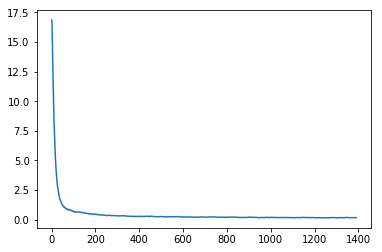

In [103]:
plt.plot(x, y)
plt.show()

Wow! Como converge! 

Ahora veamos como se comporta el entrenamiento desde que se ve ~estable.

**Últimos 400 puntos**

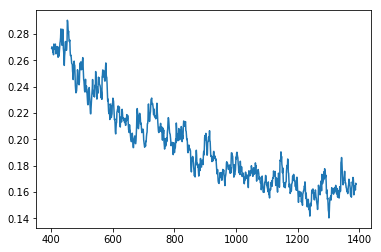

In [105]:
plt.plot(x[400:], y[400:])
plt.show()

## Pruebas

En esta sección, probaremos el sistema contra imagenes que nunca ha visto.

In [130]:
imagesList=''.join( ["<img style='width: 700px; margin: 2px; float: left; border: 1px solid black;' src='%s' />" % str(s) for s in sorted(glob('test/*.*'))])
display(HTML(imagesList))

## Resultados

Después de probar el sistema, hay dos resultados preliminares:
- El sistema es capaz de reconocer la mayoría de los carteles con las imágenes que se probó.
- En algunas imágenes, el sistema no detectó los carteles. En general esto sucede cuando las los carteles son muy pequeños en las imágenes. Esto debido a la selección de grillas con los que se entrenó YOLO. Se estima que cambiando el ajuste de entrada en el archivo `y.cfg` de 416 (416 / 32 = 13x13 grillas) a 17 grillas (17 \* 32 = 544), el sistema sería capaz de reconocer imágenes de menor tamaño pero demoraría más tiempo en entrenarse. 

**FALTA MOSTRAR AVG RECALL SOBRE IMAGENES NUEVAS**



## Conclusiones

Quedamos muy impresionados al entrenar y probar el sistema: Solo 2 horas de entrenamiento para lograr los resultados anteriores.

Si bien solo trabajamos con una clase, trabajar con más clases sería solo cosa 